In [27]:
"""
Trend Finder

Method:
1.	Find centre points of each area                                                                X
2.	Correlate each data point to its corresponding centre                                          X
3.	For each column, find an appropriate cut-off point to split the set in two                     X
4.	Find the spatial centre of each half of the dataset                                            X
5.	Determine the distance between the average centres of the two halves of the dataset            X
6.	Find the datasets with the largest distance between the averages

Intuition:
My intuition is that as the distance between the two averages grows, a larger spatial difference is observed, leading to more meaningful conclusions from the dataset.
"""

import json
import os
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pandas as pd
import numpy as np


In [42]:
params = {'figure.figsize': (20,10)}
pylab.rcParams.update(params)

In [2]:
def importData(filename):
	"""
	Import the data and restructure it, then return a much more useful tree structure of lists inside lists
	"""
	json_data = open(filename).read()
	data = json.loads(json_data)["features"]
	
	# Initialising new marital status dataset structure
	maritalStatus = []
	
	# Looping through each area
	for area in data:
		
		skipThisArea = False
		
		# coordinates is a list of all the corners of the current area
		coordinates = area["geometry"]["coordinates"][0]
		
		# These variables are used to calculate the average coordinate
		coordCount = 0
		eastSum = 0
		southSum = 0
		
		for coord in coordinates:
			coordCount += 1
			try:
				eastSum += coord[0]
				southSum += coord[1]
			except Exception:
				skipThisArea = True
		
		if skipThisArea:
			continue
		
		centreCoord = [eastSum/coordCount, southSum/coordCount]
		
		# Code that rearranges the data structure into something more useful:
		
		# Text that appears at the beginning of every column
		colBegin = "2016Census_G06_NSW_SA1_"
		
		# Initialising the restructured data
		tempArea = {"Coordinate": centreCoord, "Data": []}
		
		# Loops through sex categories:
		for sex in ["M_", "F_", "P_"]:
			
			tempAgeBracketList = []
		
			# Loops through age brackets:
			for ageBracket in ["15_19_yr_", "20_24_yr_", "25_34_yr_", "35_44_yr_", "45_54_yr_", "55_64_yr_", "65_74_yr_", "75_84_yr_", "85ov_", "Tot_"]:
				
				tempStatusList = []
				
				# Loops through marital statuses: 
				for status in ["Marrd_reg_marrge", "Married_de_facto", "Not_married"]:
					
					# Retrieve and append data into multi-levelled list structure
					try:
						tempStatusList.append(float(area["properties"][colBegin + sex + ageBracket + status])/float(area["properties"][colBegin + sex + ageBracket + "Total"]))
					except Exception:
						# Try statement to deal with potential division by zero errors
						tempStatusList.append(0)
						# print("Division by zero!")
				
				tempAgeBracketList.append(tempStatusList)
		
			tempArea["Data"].append(tempAgeBracketList)
		maritalStatus.append(tempArea)
	return maritalStatus

In [11]:
def columnDescription(ageBracket, sex, status):
	"""
	Provide an easily understandable description of a column's data
	"""
	# Setting appropriate terms to be used
	ageBrackets = ["15-19", "20-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-84", "85+",]
	sexes = ["men", "women", "people"]
	statuses = ["married", "in a De-Facto relationship", "single"]
	
	if ageBracket == 9:
		return str("All " + sexes[sex] + " that are " + statuses[status])
	else:
		return str(ageBrackets[ageBracket] + " year old " + sexes[sex] + " that are " + statuses[status])

In [4]:
def printArea(area):
	"""
	Print a single area's information nicely.
	"""
	print("Coordinate: (S " + str(area["Coordinate"][1])+ " E " + str(area["Coordinate"][0]) + ")")
	
	# Setting appropriate terms to be used while printing
	ageBrackets = ["15-19", "20-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-84", "85+",]
	sexes = ["men", "women", "people"]
	statuses = ["married", "in a De-Facto reltionship", "single"]
	
	# Looping through all the data:
	
	for ageBracket in range(10):
	
		for sex in range(3):
		
			for status in range(3):

				# Printing the data
				 print(columnDescription(ageBracket, sex, status) + ": " + str(area["Data"][sex][ageBracket][status]))

In [5]:
def retrieveColumn(maritalStatus, sex, ageBracket, status):
	"""
	Retrieve the data of every area for one column, then return it combined with the coordinate data.
	Each item of the list returned is a list with this structure: [Coordinate, Relevant Data]
	"""
	# Initialise column to return
	column = []
	
	# Loop through each area
	for area in maritalStatus:
		coord = area["Coordinate"]
		data = area["Data"][sex][ageBracket][status]
		column.append([coord, data])
	
	return column

In [6]:
def split(column):
	"""
	Split a column of data into two sub groups on either side of the average value.
	This returns a list, containing two lists of coordinates.
	"""
	# Initialising variables
	entryCount = 0
	percentageSum = 0
	
	# Summing up the values
	for entry in column:
		entryCount += 1
		percentageSum += entry[1]
	
	# Finding the average value
	splitValue = percentageSum/entryCount
	
	# Initialising lists
	belowSplit = []
	aboveSplit = []
	
	# Populating lists of coordinates
	for area in column:
		if area[1] < splitValue:
			belowSplit.append(area[0])
		else:
			aboveSplit.append(area[0])
	
	return [belowSplit, aboveSplit]

In [7]:
def findAverageDistance(points):
	"""
	Find the average points of two clusters of points and then return the distance between them.
	"""
	# Initialising list of pair of average points
	averageEastings = []
	averageSouthings = []
	
	# Finding the average points:
	for pointGroup in points:
		pointCount = 0
		eastSum = 0
		southSum = 0
		
		for point in pointGroup:
			pointCount += 1
			eastSum += point[0]
			southSum += point[1]
		try:
			averageEastings.append(eastSum/pointCount)
			averageSouthings.append(southSum/pointCount)
		except ZeroDivisionError:
			return 0
	
	# Finding the distance and returning it:
	return math.sqrt((averageEastings[0] - averageEastings[1])**2 + (averageSouthings[0] - averageSouthings[1])**2)

In [8]:
def sortColumnDistances(columnDistances):
	"""
	Sort the columnDistances list with respect to the distances (columnDistances[x][1])
	"""
	sortedDistances = []
	while len(columnDistances) != len(sortedDistances):
		# This assumes that there will be no distances higher than 999999, which is true for the current dataset
		lowestEntry = [[99, 99], 999999]
		for entry in columnDistances:
			if entry[1] < lowestEntry[1] and entry not in sortedDistances:
				lowestEntry = entry
		sortedDistances.append(lowestEntry)
	return sortedDistances

In [18]:
def run(verbose=False):
	"""
	Run the other functions.
	"""
	maritalStatus = importData("fullDataset.json")

	# My decently beefy laptop wasn't able to do the following line, so good luck if you want to.
	# print(maritalStatus)
	# input1 = raw_input("Press enter to continue.")
	
	if verbose:
		# Printing the coordinates of every area
		for area in maritalStatus:
			print area["Coordinate"]
		input1 = raw_input("Press enter to continue.")
		
		# Testing out the printArea function
		printArea(maritalStatus[0])
		input1 = raw_input("Press enter to continue.")
	
		# Testing out the retrieveColumn function
		print(retrieveColumn(maritalStatus, 2, 2, 2))
	
	# Initialising list of column distances
	columnDistances = []
	
	for sex in range(3):
	
		for ageBracket in range(10):
		
			for status in range(3):
				# Appends spatial difference value of a certain column alongside its name
				columnDistances.append([columnDescription(ageBracket, sex, status), findAverageDistance(split(retrieveColumn(maritalStatus, sex, ageBracket, status)))])

	columnDistances = sortColumnDistances(columnDistances)
	
	return columnDistances

In [39]:
columnDistances = run()

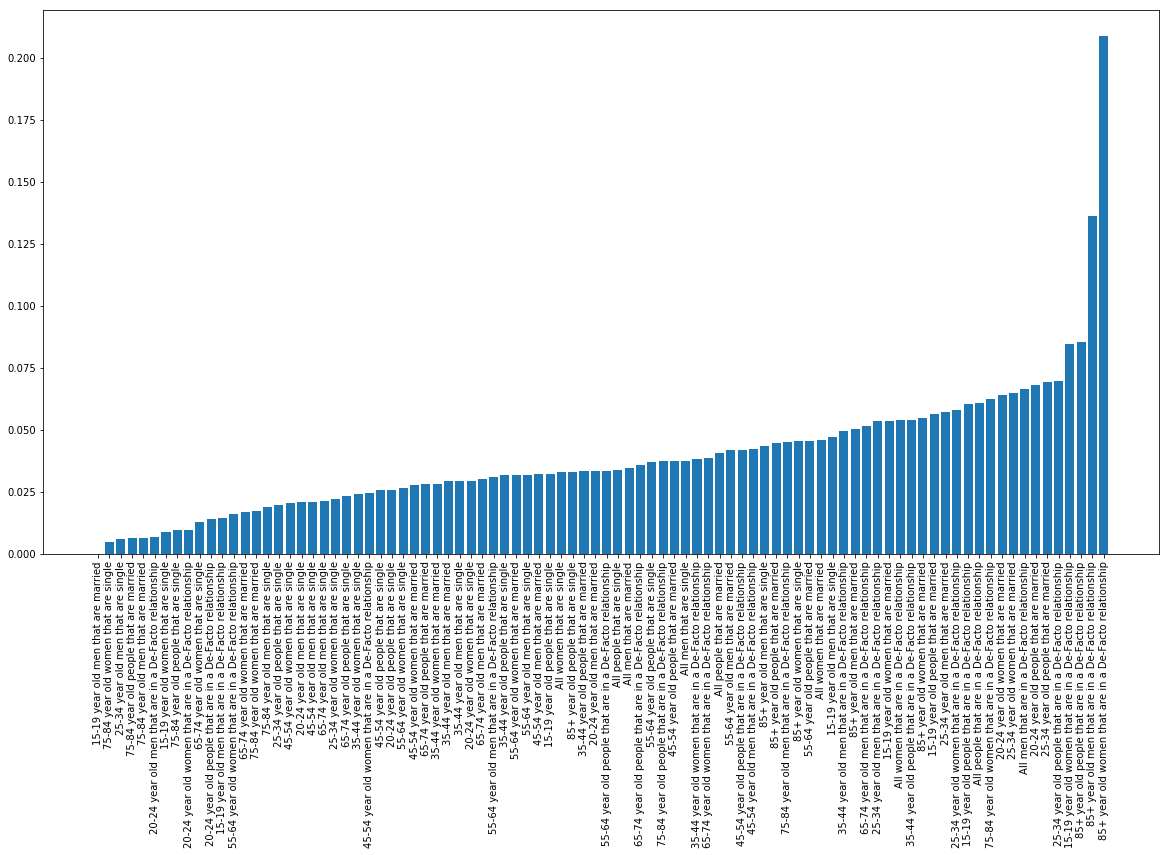

In [44]:
distValues = []
distNames = []

for entry in columnDistances:
    distValues.append(entry[1])
    distNames.append(entry[0])

yPos = np.arange(len(distValues))

plt.bar(yPos, distValues)

plt.xticks(yPos, distNames, rotation=90)

plt.show()
# print colDist
# colDist.plot(kind='bar')